## Parse all images to text

merged: 8
filtered: 5
last_rect: 5
[[507 219]
 [858 219]
 [858 458]
 [507 458]]
[[ 19 103]
 [392 103]
 [392 302]
 [ 19 302]]
[[ 51 363]
 [399 363]
 [399 445]
 [ 51 445]]
[[ 47 507]
 [383 507]
 [383 576]
 [ 47 576]]
[[331  20]
 [413  19]
 [414  61]
 [332  62]]
Cropped image saved to cropped_images\cropped_0.png
Cropped image saved to cropped_images\cropped_1.png
Cropped image saved to cropped_images\cropped_2.png
Cropped image saved to cropped_images\cropped_3.png
Cropped image saved to cropped_images\cropped_4.png


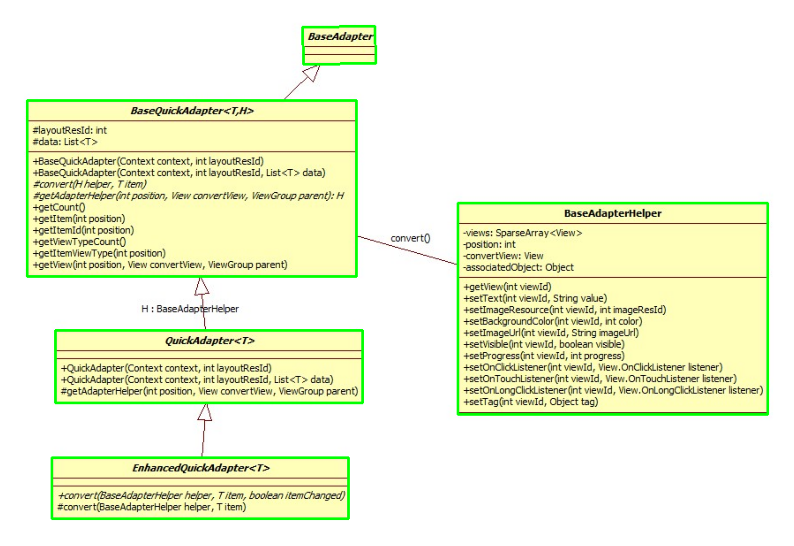

In [1]:
from pythonscript.rectangle_parser import run_parser
image_path = 'data_models/17_android-open-project-analysis/base-adapter-helper-ClassDiagram.jpg'

run_parser(image_path)

## Save the text as file

In [1]:
from pythonscript.image_to_text import run_text
run_text('cropped_images')

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

## Conversion svg to png

In [28]:
from pythonscript.converting_files_svg_to_png import run_conversion
run_conversion()

65_gotalk
38_textlint
92_wicket
56_chrome-devtools-app
96_diode
18_google-api-python-client
11_sonarqube
61_unknown-horizons
47_game-of-life
63_n2o
12_QGIS
40_spring-batch
.DS_Store
94_swift-lldb
29_netty-learning
46_grobid
10_azure-content
23_Gadgetbridge
98_gamehub.io
69_anki-3d-engine
86_dataverse
93_swift-clang
44_incubator-geode
8_Activiti
58_pjproject
33_optaplanner
76_Dnn.Platform
81_activejdbc
1_kubernetes
82_spring-net
34_core-plot
55_octomap
97_platform
89_efficientR
4_odoo
100_docs
39_bitcoin-on-nodejs
32_RakNet
50_yard
62_MVVM.CEF.Glue
72_sipsorcery
21_HP-Socket
84_busmaster
35_UVCCamera
90_Seccubus_v2
79_activemq-artemis
67_OpenDDS
42_react-starter
45_gobblin
2_spring-framework
41_h2o-2
15_GoJS
74_di
20_h2o-3
78_elmerfem
91_aces-dev
53_LibrePCB
31_ogre
85_jenetics
43_monodroid-samples
75_usergrid
37_android_design_patterns_analysis
87_isis
5_elasticsearch-analysis-ik
13_jmeter
60_Dynamo
66_ImagePlay
73_sonar-java
99_jsoup-learning
80_DebugViewPP
30_game-programming-pattern

'All SVG files have been converted to PNG.'

## Conversion gif to png

In [29]:
from pythonscript.converting_files_gif_to_png import run_gif_conversion
run_gif_conversion('data_models/18_google-api-python-client')

Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_21.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_21.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_20.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_20.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_22.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_22.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_9.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_9.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_37.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_37.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_18.gif to data_models/18_google-api-python-client/uml_class_diagram_for_goog